In [82]:
from libsparql import *

# Liste des métiers disposant de catégories sur Wikipédia en français

Environ 1200 métiers au total

In [83]:
wdq(preprocess("""
 select distinct ?metierLabel (strafter(?itemcatName, ":") as ?cat) {
  ?metier wdt:P31/wdt:P279* wd:Q28640 .
  ?itemcat wdt:P301 ?metier .
  [] schema:about ?itemcat ;
       schema:isPartOf <https://fr.wikipedia.org/> ;
       schema:name ?itemcatName .
   
   c:label_service()
}
"""), width=1000, height=300)

# Quelques statistiques sur ces métiers et les personnes les exercant sur Wikipédia

Pour chacun de ces métiers, calcul du nombre de personnes ayant des articles sur WP qui les exercent

In [84]:
taille_echantillon=30000
graine = 100

query=preprocess(""" 
  select (count(?human) as ?count) {{ 
     c:human_sample({graine}, ?human, {taille_echantillon})
     c:has_an_article(?human)
  }}""".format(taille_echantillon=taille_echantillon, graine=graine))

query_human_count = preprocess(""" 
  select (count(*) as ?count) {{ 
     [] wdt:P31 wd:Q5 .
  }}""")


resultats = querySparql(query)
      
effectifs = int(resultats[0]["count"]["value"])

resultats_tot_humains = querySparql(query_human_count)

                               
nb_humains_wd = int(resultats_tot_humains[0]["count"]["value"])
pourcent = round(effectifs * 100 / taille_echantillon, 2)
nb_humains_wp = int(pourcent * nb_humains_wd / 100)

print("""Sur un échantillon de {} humains de Wikidata, on a {} articles sur Wikipédia en français, soit {}%. 
   Il y a en tout {} humains sur Wikidata, donc environ {} humains sur Wikpédia en français, en extropolant."""
      .format(taille_echantillon, effectifs, pourcent, nb_humains_wd, nb_humains_wp))


Sur un échantillon de 30000 humains de Wikidata, on a 1951 articles sur Wikipédia en français, soit 6.5%. 
   Il y a en tout 10357479 humains sur Wikidata, donc environ 673236 humains sur Wikpédia en français, en extropolant.


In [85]:
query = preprocess("""
 select distinct 
        ?metier
        (strafter(?itemcatName, ":") as ?cat)
        (count(?human) as ?effectif) 
        (round(?effectif * 10000 / {effectifs})/100 as ?pourcent)
        (round(?pourcent * {nb_wp} / 100) as ?tot_wp) {{
  ?metier wdt:P31/wdt:P279* wd:Q28640 .
  ?itemcat wdt:P301 ?metier .
  ?cat schema:about ?itemcat ;
       schema:isPartOf <https://fr.wikipedia.org/> ;
       schema:name ?itemcatName .
        
    ?human wdt:P106 ?metier .
    
   c:human_sample({graine}, ?human, {taille_echantillon})
   c:has_an_article(?human)
}} group by ?metier ?metierLabel ?cat ?itemcatName ?itemcat order by desc(?effectif)
""".format(taille_echantillon=taille_echantillon, effectifs=effectifs, graine=graine, nb_wp=nb_humains_wp))

import pandas as pd

result = querySparql(query)
wdq(query)

Sur les 1200 métiers au total, sur notre échantillon 2000 humains de notre échantillon, on a environ 350 métiers avec au moins une personne l’exerçant

In [86]:

#chargement dans panda
pourcent_df = result_to_dataframe(result)

#affichage des données

In [87]:
s = pd.Series(pourcent_df["effectif"])

## Distribution des effectifs en fonction des catégories, il y a quelques catégories avec beaucoup d’effectif et beaucoup de catégories avec peu d’effectif.

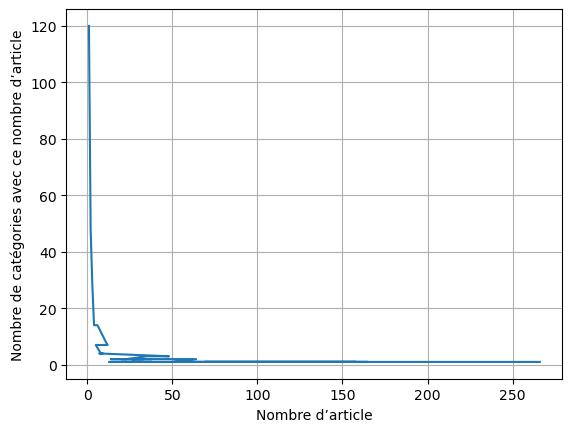

In [88]:
plot = s.value_counts().plot(grid=True)
#plot = s.plot(grid=True)
 
#plot.set_xlabel("Nombre d’article")
#plot.set_ylabel("Nombre de catégories avec ce nombre d’article")
#plot.transpose()
t=plot.set_xlabel("Nombre d’article")
t=plot.set_ylabel("Nombre de catégories avec ce nombre d’article")


En échelle log-log, ça semble faire une droite, on dirait une [Loi de zipf](https://fr.wikipedia.org/wiki/Loi_de_Zipf).

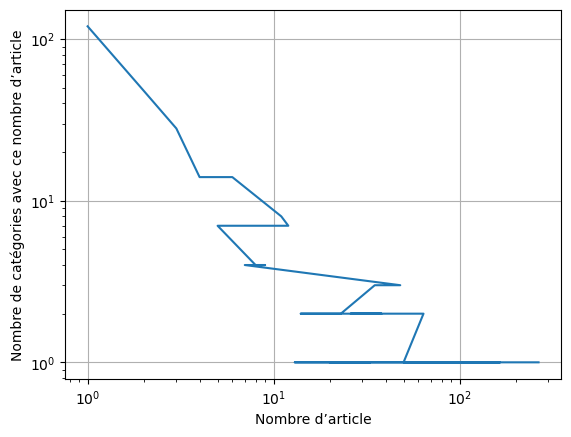

In [89]:
plot = s.value_counts().plot(grid=True,logx=True,logy=True)

t=plot.set_xlabel("Nombre d’article")
t=plot.set_ylabel("Nombre de catégories avec ce nombre d’article")


# métiers et genre

## Répartition des effectifs sur l’échantillon aléatoire

In [90]:
query=preprocess(""" 
  select ?genre ?genreLabel (count(?human) as ?count) (round(100*?count*100/{eff})/100 as ?pourcent){{ 
     c:human_sample({graine}, ?human, {taille_echantillon})
     c:has_an_article(?human) 
     ?human wdt:P21 ?genre.
     c:label_service()
  }} group by ?genre ?genreLabel order by desc(?count)""".format(taille_echantillon=taille_echantillon, graine=graine,eff=effectifs))

result = result_to_dataframe(querySparql(query))

In [91]:
rapport_homme_femme = result.at[0, "count"] / result.at[1,"count"]
print("Rapport homme femme sur l’échantillon : {:.2f} hommes pour une femme".format(rapport_homme_femme))
result

Rapport homme femme sur l’échantillon : 3.97 hommes pour une femme


,genre,genreLabel,count,pourcent
0,http://www.wikidata.org/entity/Q6581097,masculin,1544,79.14
1,http://www.wikidata.org/entity/Q6581072,féminin,389,19.94
2,http://www.wikidata.org/entity/Q2449503,homme trans,2,0.10
3,http://www.wikidata.org/entity/Q1052281,femme trans,1,0.05
4,http://www.wikidata.org/entity/Q1399232,fa'afafine,1,0.05


En général environ 80% masculin, 20% féminin et parfois quelques personnes trans ou non binaires dans l’échantillon. 

Le faible effectif des personnes non strictement masculine / féminine fait qu’il faudrait les traiter à part et spécifiquement. En première approximation, un traitement compliquerait le traitement technique, allongerait les temps de calcul (et les risques de non aboutissement) et serait peu significatif. De l’ordre de quelques pour mille des effectifs … Une meilleure approche pour les prendre en compte serait de poser la question sous l’angle "quelles sont les professions des personnes trans / non binaires / …", pas fait ici pour l’instant.

## Métiers pratiqués par les femmes sur l’échantillon


In [92]:
query=preprocess("""
 select distinct ?metier (strafter(?itemcatName, ":") as ?cat)
        (count(?human) as ?effectif) 
        (round(?effectif * 10000 / {effectifs})/100 as ?pourcent)
        (round(?pourcent * {nb_wp} / 100) as ?tot_wp) 
        {{
  ?metier wdt:P31/wdt:P279* wd:Q28640 .
  ?itemcat wdt:P301 ?metier .
  ?cat schema:about ?itemcat ;
       schema:isPartOf <https://fr.wikipedia.org/> ;
       schema:name ?itemcatName .
        
    ?human wdt:P106+ ?metier ;
           wdt:P21 wd:Q6581072 .
    
   
   c:human_sample({graine}, ?human, {taille_echantillon})
   c:has_an_article(?human)
}} group by ?metier ?metierLabel ?cat ?itemcatName ?itemcat order by desc(?effectif) 
""".format(taille_echantillon=taille_echantillon, effectifs=effectifs, graine=graine, nb_wp=nb_humains_wp))

print("""Une ligne de tableau comme la suivante :
  metier        	cat              	effectif	pourcent	tot_wp
  'wd:Q60723829'	'Chanteur de pop'	'1'     	'0.05'  	'338'\n

se lit : 'pour le métier <chanteur de pop> (Q60723829) on a <1> personne avec un article dans notre échantillon, 
          soit <0.05%> de notre échantillon, avec une estimation d’environ <338> articles au total sur Wikipédia en entier (extrapolation)  """)

result_femmes = querySparql(query)
wdq(query, width=1000)

Une ligne de tableau comme la suivante :
  metier        	cat              	effectif	pourcent	tot_wp
  'wd:Q60723829'	'Chanteur de pop'	'1'     	'0.05'  	'338'


se lit : 'pour le métier <chanteur de pop> (Q60723829) on a <1> personne avec un article dans notre échantillon, 
          soit <0.05%> de notre échantillon, avec une estimation d’environ <338> articles au total sur Wikipédia en entier (extrapolation)  


## Comparaison hommes / femmes sur l’échantillon pour les métiers les plus représentés


In [93]:
df_metiers = pourcent_df.set_index("cat") 
df_femmes = result_to_dataframe(result_femmes).set_index("cat")
df_cmp = df_femmes[["effectif"]].join(df_metiers[["effectif", "pourcent"]], rsuffix="_tot", lsuffix="_femmes").drop_duplicates()
df_cmp = df_cmp[df_cmp["effectif_tot"] >= 5]
df_cmp["ratio"] = (df_cmp["effectif_tot"] - df_cmp["effectif_femmes"]) / df_cmp["effectif_femmes"]

## Catégories classées par le nombre d’hommes pour une femme sur l’échantillon 

On prend ici uniquemement les catégories pour lesquelles on a au moins 5 articles dans l’échantillon

La catégorie "historien" semble la/une des plus déséquilibrée plus déséquilibrée avec 32 hommes pour une femme. Suivie par les pratiquants et pratiquantes du rugby à XV, avec 24 hommes pour une femmes, et les dilomates (23) et les footballeurs (20)


Une ligne du tableau comme la suivante se lit 

* _"Catégorie:Personnalité militaire" 	"1" 	"40.0" 	"2.10" 	"39.00" :_

_Pour les personnalité militaires, on a <1> femme sur <40.0> articles (ces 40 forment <2,10>% du total des articles). On a donc <39> hommes pour une femme sur l’échantillon._

In [94]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 2,
                      ):
    display(df_cmp.sort_values("ratio", ascending=False))

,effectif_femmes,effectif_tot,pourcent,ratio
cat,,,,
Personnalité militaire,1,48,2.46,47.00
Diplomate,2,76,3.90,37.00
Joueur de hockey sur glace,1,33,1.69,32.00
Ingénieur,1,23,1.18,22.00
Officier,1,22,1.13,21.00
Sculpteur,1,18,0.92,17.00
Footballeur,10,165,8.46,15.50
Chef d'orchestre,2,32,1.64,15.00
Peintre,6,79,4.05,12.17


##  Catégories classées par équilibre / déséquilibre
Chanteuse 	femme > 	1.1 	70

Les métiers sont ici classés par équilibres hommes femmes. Les catégories équilibrées, c’est à dire avec un nombre de femme et d’homme à peu près égal sont mises en premier, et celle avec soit beaucoup d’hommes pour une femmes ou l’inverse sont mises en dernier.

Une ligne comme :
catégories

In [95]:
df_equilibre = df_cmp.loc[:,("effectif_tot","ratio")]
def calc_maj(row):
    #print(row)
    return ("homme > " if row > 1 else "femme >" if row < 1 else "=")

def cmp_ratio_wp(ratio):
    #print(row)
    return ("+ d’homme que wp" if ratio > rapport_homme_femme else "+ de femme que wp" if rapport_homme_femme > ratio else "=")


#df_equilibre["majorite"] = 
df_equilibre["majorité"] = df_cmp["ratio"].map(calc_maj)
df_equilibre["ratio"] = df_cmp["ratio"].map(lambda rat : rat if (rat > 1) else 10000 if rat == 0 else (1/rat) ) 

df_equilibre["comp ratio WP"] = df_cmp["ratio"].map(cmp_ratio_wp)

print("""Une ligne comme

    «cat                 	majorité	ratio  	effectif_tot    comp ratio WP»
    «Avocat              	homme > 	8.8    	78              + d’homme que wp»
    
se lit : pour les <avocat>s, on a <78> personnes avec un article sur Wikipédia en français exerçant le métier,
         avec <8.8> hommes pour une femme, et il y a plus d’hommes pour une femme que sur l’ensemble de wikipédia.
    
    «Conservateur de musée 	=       	1.0    	6               + de femme que wp»

se lit : pour les <conservateur de musée>s, on a <6> personnes avec un article sur Wikipédia en français exerçant le métier,
         avec <1> homme pour une femme, et il y a plus de femme pour un homme que sur l’ensemble de wikipédia


    
    «Chanteuse             	femme > 	1.1    	70              + de femme que wp»
    
se lit : pour les <chanteuse>s, on a <78> personnes avec un article sur Wikipédia en français exerçant le métier,
         avec <8.8> *femmes* pour un homme, cette fois, avec plus de femme pour un homme que sur l’ensemble de wp.
         
         
** Un ratio de 10000 indique que la totalité de l’effectif est d’un unique genre **

""")

with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.precision', 1):
    
    display(df_equilibre[["majorité","ratio","effectif_tot","comp ratio WP"]].sort_values("ratio", ascending=True))


print("pour l’échantillon au total, on a un rapp {:.1f}".format(rapport_homme_femme))


Une ligne comme

    «cat                 	majorité	ratio  	effectif_tot    comp ratio WP»
    «Avocat              	homme > 	8.8    	78              + d’homme que wp»
    
se lit : pour les <avocat>s, on a <78> personnes avec un article sur Wikipédia en français exerçant le métier,
         avec <8.8> hommes pour une femme, et il y a plus d’hommes pour une femme que sur l’ensemble de wikipédia.
    
    «Conservateur de musée 	=       	1.0    	6               + de femme que wp»

se lit : pour les <conservateur de musée>s, on a <6> personnes avec un article sur Wikipédia en français exerçant le métier,
         avec <1> homme pour une femme, et il y a plus de femme pour un homme que sur l’ensemble de wikipédia


    
    «Chanteuse             	femme > 	1.1    	70              + de femme que wp»
    
se lit : pour les <chanteuse>s, on a <78> personnes avec un article sur Wikipédia en français exerçant le métier,
         avec <8.8> *femmes* pour un homme, cette fois, avec plus de femme

,majorité,ratio,effectif_tot,comp ratio WP
cat,,,,
Menuisier,=,1.0,6,+ de femme que wp
Auteur-compositeur-interprète,=,1.0,16,+ de femme que wp
Biologiste,femme >,1.2,11,+ de femme que wp
Romancier,homme >,1.3,23,+ de femme que wp
Acteur,homme >,1.4,158,+ de femme que wp
Chanteuse,femme >,1.4,69,+ de femme que wp
Scientifique,homme >,1.5,5,+ de femme que wp
Biathlète,homme >,1.7,8,+ de femme que wp
Artiste,homme >,2.0,9,+ de femme que wp


pour l’échantillon au total, on a un rapp 4.0


Une valeur de 10000 pour un métier indique que la totalité de l’échantillon est d’un genre / sexe

Métiers avec, sur l’échantillon d’article de biographies, uniquement des hommes le pratiquant:

In [96]:
metiers = [metier for metier in df_metiers.index.difference(df_femmes.index)]
import numpy as np

with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.precision', 1):
    num_columns = 4
    display(
        pd.DataFrame(np.array_split(metiers, len(metiers) / num_columns)).fillna("")
    )

,0,1,2,3,4
0,Acteur de doublage,Affichiste,Agent de joueurs,Agronome,Anatomiste
1,Animateur,Animateur de radio,Apiculteur,Aquafortiste,Aquarelliste
2,Arbitre de football,Archevêque,Architecte,Architecte d'intérieur,Archiviste
3,Archéologue,Armateur,Artiste conceptuel,Artiste d'installation,
4,Artiste de cirque,Artiste de vidéo,As de l'aviation,Astronaute,
5,Astrophysicien,Aviateur,Avocat britannique,Banquier,
6,Batteur,Bibliographe,Biochimiste,Blogueur,
7,Botaniste,Bryologiste,Caricaturiste,Cartographe,
8,Chef d'entreprise,Chef décorateur,Chirurgien,Chirurgien cardiovasculaire,
9,Chroniqueur (histoire),Chronologiste,Claviériste,Climatologue,


Métiers avec moins de 5 personnes l’exerçant sur l’échantillon de biographies :

In [97]:
effectif_ins = [metier for metier in df_metiers[df_metiers["effectif"] < 5].index]

with pd.option_context(
    'display.max_rows', None,
    'display.max_columns', None,
    'display.precision', 1):
    display(
        pd.DataFrame(np.array_split(
            effectif_ins,
            len(effectif_ins) / num_columns
        )).fillna("")
    )

,0,1,2,3,4
0,Pédagogue,Chorégraphe,Géologue,Psychologue,Handballeur
1,Astrophysicien,Critique musical,Biographe,Industriel,Officier de marine
2,Métier du social,Chercheur,Inventeur,Chansonnier,
3,Directeur de la photographie,Avocat britannique,Cuisinier,Infirmière,
4,Dentiste,Historien moderniste,Skipper,Judoka,
5,Directeur artistique,Géographe,Alpiniste,Archiviste,
6,Artiste de vidéo,Paléontologue,Aviateur,Imprimeur,
7,Entraîneur sportif,Personnalité liée au secteur de l'informatique,Biologiste marin,Universitaire,
8,Pilote de rallye,Espion,Entraîneur de biathlon,Conservateur de musée,
9,Plongeur,Rappeur,Organiste,Percussionniste,
